**4장 – 모델 훈련**

_이 노트북은 4장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/04_training_linear_models.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 정규 방정식을 사용한 선형 회귀

In [2]:
import numpy as np

X = 2 * np.random.rand(100, 1) # 균등분포 0~2 난수, 100*1 크기의 행렬
y = 4 + 3 * X + np.random.randn(100, 1) # 표준정규분포

그림 저장: generated_data_plot


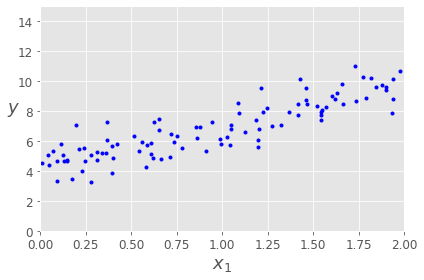

In [3]:
plt.style.use('ggplot')
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

**식 4-4: 정규 방정식**

$\hat{\boldsymbol{\theta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$

In [4]:
X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0 = 1을 추가합니다. # 열 방향으로 array끼리 합침.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [5]:
theta_best

array([[4.21509616],
       [2.77011339]])

$\hat{y} = \mathbf{X} \boldsymbol{\hat{\theta}}$

In [6]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # 모든 샘플에 x0 = 1을 추가합니다.
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

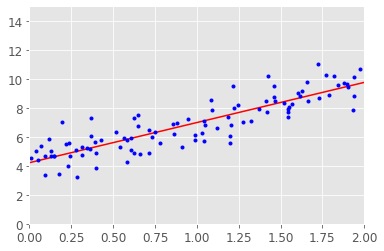

In [7]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

책에 있는 그림은 범례와 축 레이블이 있는 그래프입니다:

그림 저장: linear_model_predictions_plot


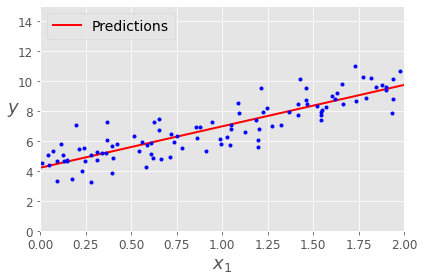

In [8]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

In [9]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [10]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

`LinearRegression` 클래스는 `scipy.linalg.lstsq()` 함수("least squares"의 약자)를 사용하므로 이 함수를 직접 사용할 수 있습니다:

In [11]:
# 싸이파이 lstsq() 함수를 사용하려면 scipy.linalg.lstsq(X_b, y)와 같이 씁니다.
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

이 함수는 $\mathbf{X}^+\mathbf{y}$을 계산합니다. $\mathbf{X}^{+}$는 $\mathbf{X}$의 _유사역행렬_ (pseudoinverse)입니다(Moore–Penrose 유사역행렬입니다). `np.linalg.pinv()`을 사용해서 유사역행렬을 직접 계산할 수 있습니다:

$\boldsymbol{\hat{\theta}} = \mathbf{X}^{-1}\hat{y}$

In [12]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

# 배치 경사 하강법을 사용한 선형 회귀

전체 데이터에서 비용 함수를 최소화(기울기가 0)하기 위해 반복적으로 모델 파라미터(theta)를 조정

임의의 학습 스텝(학습률)에 따라 최솟값을 구해가는 과정


학습 스텝이 너무 크면 최솟값을 건너 뛰고

학습 스텝이 너무 작으면 학습 시간이 너무 오래 걸리는 단점



---


단점 

 
 최솟값이 아닌 극솟값을 최솟값으로 판단할 수도 있음.

 최솟값이 아닌 기울기가 0인 지점을 최솟값으로 판단할 수도 있음.



**식 4-6: 비용 함수의 그레이디언트 벡터**

$
\dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
 = \dfrac{2}{m} \mathbf{X}^T (\mathbf{X} \boldsymbol{\theta} - \mathbf{y})
$

**식 4-7: 경사 하강법의 스텝**

$
\boldsymbol{\theta}^{(\text{next step})} = \boldsymbol{\theta} - \eta \dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
$


In [13]:
eta = 0.1  # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # 랜덤 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [14]:
theta

array([[4.21509616],
       [2.77011339]])

In [15]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

In [16]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

그림 저장: gradient_descent_plot


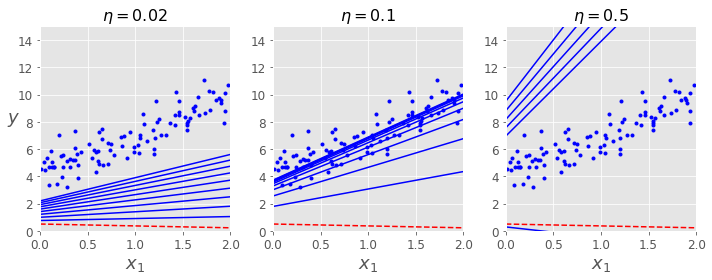

In [17]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()
# 적절한 학습률이 중요!

# 확률적 경사 하강법

전체 데이터에서 일부만 활용

에포크(큰 반복) 시작

 - 훈련 세트 시작
   1. 훈련 세트에서 샘플 하나 꺼내기
   2. 경사 하강법 수행
   3. 모델 파라미터 수정
   4. 수정
  - 반복
 - 종료

In [18]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

그림 저장: sgd_plot


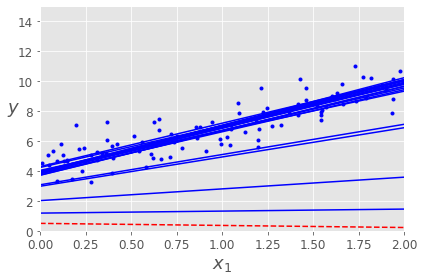

In [19]:
n_epochs = 50
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # 랜덤 초기화

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # 책에는 없음
            y_predict = X_new_b.dot(theta)           # 책에는 없음
            style = "b-" if i > 0 else "r--"         # 책에는 없음
            plt.plot(X_new, y_predict, style)        # 책에는 없음
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # 책에는 없음

plt.plot(X, y, "b.")                                 # 책에는 없음
plt.xlabel("$x_1$", fontsize=18)                     # 책에는 없음
plt.ylabel("$y$", rotation=0, fontsize=18)           # 책에는 없음
plt.axis([0, 2, 0, 15])                              # 책에는 없음
save_fig("sgd_plot")                                 # 책에는 없음
plt.show()                                           # 책에는 없음

In [20]:
theta

array([[4.21076011],
       [2.74856079]])

In [21]:
from sklearn.linear_model import SGDRegressor # 확률적 경사 하강법

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
# max_iter : 에포크 , tol = 1e-3 : tol가 1e-3보다 크지 않으면 최적인 모델, eta0 : 학습률 
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [22]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

# 미니배치 경사 하강법

전체 데이터를 batch_size개씩 나눠 각각 경사하강법 수행

batch_size는 사용자가 설정

계산량이 배치 경사하강법보다 적음

지역 최솟값을 찾을 확률을 줄일 수 있음.

In [23]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [24]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [25]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

그림 저장: gradient_descent_paths_plot


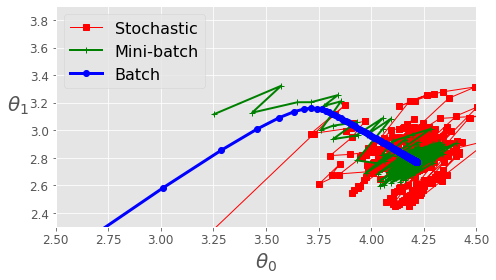

In [26]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

# 다항 회귀

In [27]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [28]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

그림 저장: quadratic_data_plot


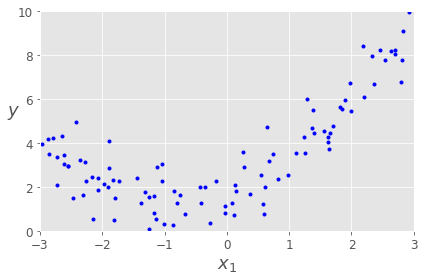

In [29]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

In [30]:
from sklearn.preprocessing import PolynomialFeatures # 데이터를 다항식 형태로 변환
poly_features = PolynomialFeatures(degree=2, include_bias=False) # 2차 다항식, 편차x
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [31]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [32]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

그림 저장: quadratic_predictions_plot


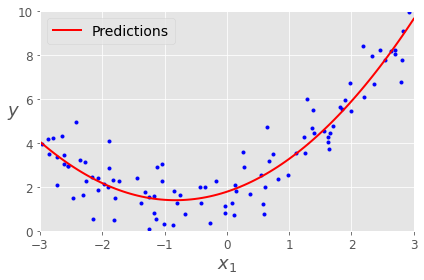

In [33]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

그림 저장: high_degree_polynomials_plot


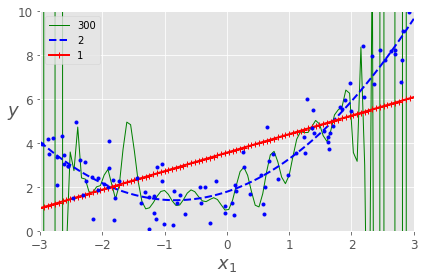

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # 책에는 없음
    plt.xlabel("Training set size", fontsize=14) # 책에는 없음
    plt.ylabel("RMSE", fontsize=14)              # 책에는 없음

그림 저장: underfitting_learning_curves_plot


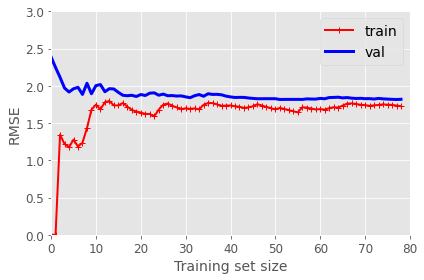

In [36]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # 책에는 없음
save_fig("underfitting_learning_curves_plot")   # 책에는 없음
plt.show()                                      # 책에는 없음

그림 저장: learning_curves_plot


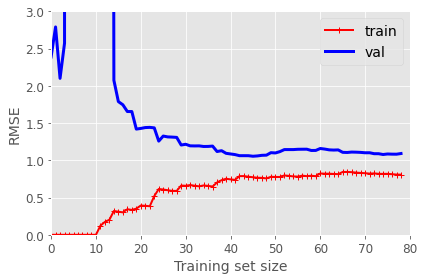

In [37]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # 책에는 없음
save_fig("learning_curves_plot")  # 책에는 없음
plt.show()                        # 책에는 없음

# 규제가 있는 모델

In [38]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1) # [0,3]에서 100개의 데이터

**식 4-8: 릿지 회귀의 비용 함수**

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \dfrac{1}{2}\sum\limits_{i=1}^{n}{\theta_i}^2
$

In [39]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42) # alpha : 모델에 규제를 가하는 하이퍼파라미터 # 상수항은 규제x
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [40]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

그림 저장: ridge_regression_plot


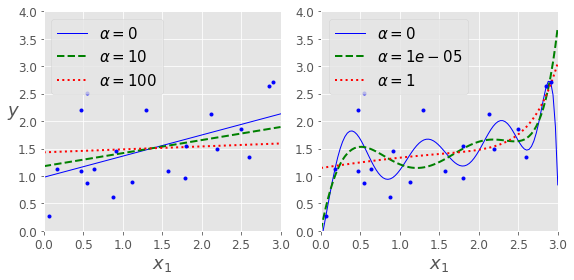

In [41]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

**노트**: 향후 버전이 바뀌더라도 동일한 결과를 만들기 위해 사이킷런 0.21 버전의 기본값인 `max_iter=1000`과 `tol=1e-3`으로 지정합니다.

In [42]:
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42) # penalty = 'l2' : ridge 모델의 손실함수
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

**식 4-10: 라쏘 회귀의 비용 함수**

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right|
$

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.802867703827423, tolerance: 0.0009294783355207351
  positive)


그림 저장: lasso_regression_plot


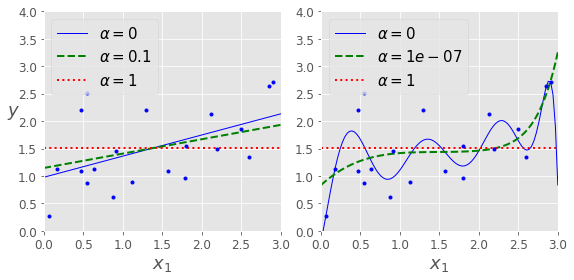

In [43]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

In [44]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

**식 4-12: 엘라스틱넷 비용 함수**

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + r \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right| + \dfrac{1 - r}{2} \alpha \sum\limits_{i=1}^{n}{{\theta_i}^2}
$

In [45]:
from sklearn.linear_model import ElasticNet

# Lasso == ElasticNet(l1_ratio=1.0)
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42) # l1_ratio : r
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

In [46]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

조기 종료 예제:

조기종료란 경사하강법과 같이 반복학습 알고리즘을 규제하는 방법으로, 검증 에러가 최솟값에 도달하면 훈련을 중지(조기 종료)시키는 것이다.

In [47]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 중지된 곳에서 다시 시작합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

그래프를 그립니다:

그림 저장: early_stopping_plot


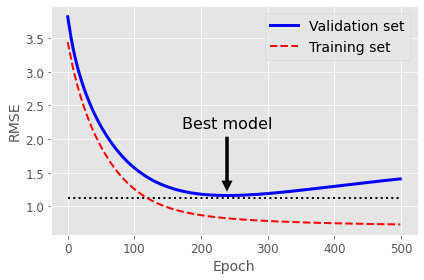

In [48]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

In [49]:
best_epoch, minimum_val_error ,best_model

(239,
 1.3513110512453865,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
              eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
              learning_rate='constant', loss='squared_loss', max_iter=1,
              n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
              shuffle=True, tol=-inf, validation_fraction=0.1, verbose=0,
              warm_start=True))

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [51]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

그림 저장: lasso_vs_ridge_plot


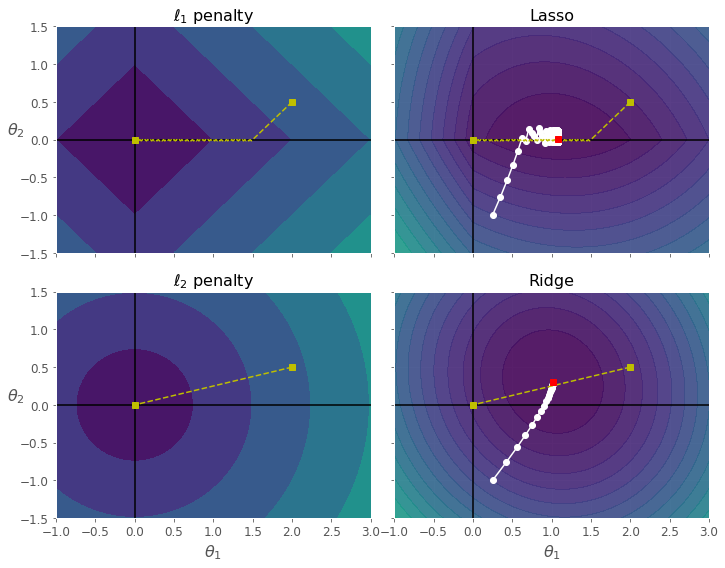

In [52]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

save_fig("lasso_vs_ridge_plot")
plt.show()

# 로지스틱 회귀

0보다 크면 양성 클래스


0보다 작으면 음성 클래스로 분류

그림 저장: logistic_function_plot


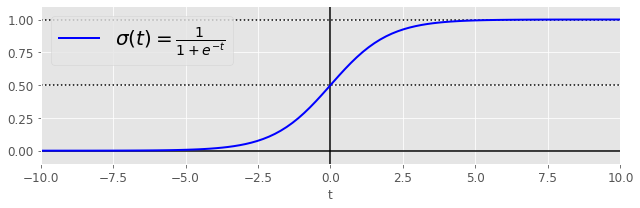

In [53]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
save_fig("logistic_function_plot")
plt.show()

확률값이 0.5보다 크면 양성 클래스

확률값이 0.5보다 작으면 음성 클래스

**식 4-16: 하나의 훈련 샘플에 대한 비용 함수**

$
c(\boldsymbol{\theta}) =
\begin{cases}
  -\log(\hat{p}) & \text{if } y = 1, \\
  -\log(1 - \hat{p}) & \text{if } y = 0.
\end{cases}
$


**식 4-17: 로지스틱 회귀 비용 함수(로그 손실)**

$
J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}
$


**식 4-18: 로지스틱 비용 함수의 편도 함수**

$
\dfrac{\partial}{\partial \theta_j} \text{J}(\boldsymbol{\theta}) = \dfrac{1}{m}\sum\limits_{i=1}^{m}\left(\mathbf{\sigma(\boldsymbol{\theta}}^T \mathbf{x}^{(i)}) - y^{(i)}\right)\, x_j^{(i)}
$

In [54]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [55]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [56]:
X = iris["data"][:, 3:]  # 꽃잎 너비
y = (iris["target"] == 2).astype(np.int)  # Iris virginica이면 1 아니면 0

In [57]:
np.unique(iris.target,return_counts=True)

(array([0, 1, 2]), array([50, 50, 50]))

**노트**: 향후 버전이 바뀌더라도 동일한 결과를 만들기 위해 사이킷런 0.22 버전의 기본값인 `solver="lbfgs"`로 지정합니다.

In [58]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

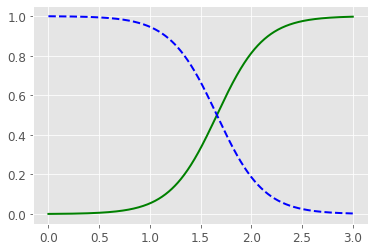

In [59]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

책에 실린 그림은 조금 더 예쁘게 꾸몄습니다:

/usr/local/lib/python3.7/dist-packages/matplotlib/patches.py:1327: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  verts = np.dot(coords, M) + (x + dx, y + dy)


그림 저장: logistic_regression_plot


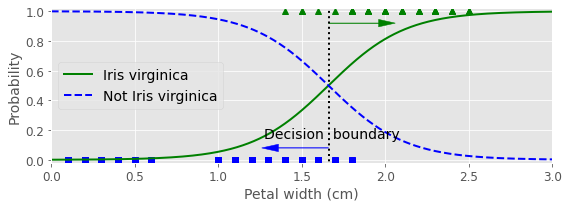

In [60]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

In [61]:
decision_boundary # 1.66보다 크면 양성 -> virginica
                  # 1.66보다 작거나 같으면 음성

array([1.66066066])

In [62]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

그림 저장: logistic_regression_contour_plot


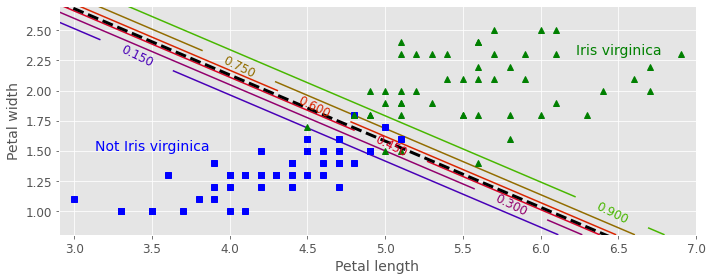

In [63]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
# meshgrid : 1차원 좌표 배열에서 n차원 직사각형 격자를 만드는 함수
# x0 500 구간이 200번 반복
# x1 200 구간이 500번 반복
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

**식 4-20: 소프트맥스 함수**

$
\hat{p}_k = \sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}
$

**식 4-22: 크로스 엔트로피 비용 함수**

$
J(\boldsymbol{\Theta}) = - \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}
$

**식 4-23: 클래스 k에 대한 크로스 엔트로피의 그레이디언트 벡터**

$
\nabla_{\boldsymbol{\theta}^{(k)}} \, J(\boldsymbol{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}
$

In [64]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

그림 저장: softmax_regression_contour_plot


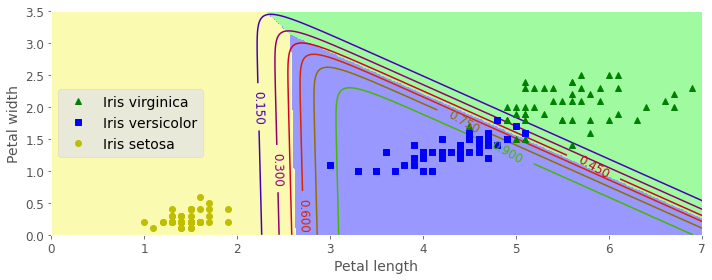

In [65]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0']) # 확률값에 따라 색깔을 다르게 줌

plt.contourf(x0, x1, zz, cmap=custom_cmap) 
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg) # 등고선
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()

In [66]:
softmax_reg.predict([[5, 2]])

array([2])

In [67]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

# 연습문제 해답

## 1. to 11.

부록 A를 참고하세요.

## 12. 조기 종료를 사용한 배치 경사 하강법으로 소프트맥스 회귀 구현하기
(사이킷런을 사용하지 않고)

먼저 데이터를 로드합니다. 앞서 사용했던 Iris 데이터셋을 재사용하겠습니다.

In [68]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 넓이
y = iris["target"]

모든 샘플에 편향을 추가합니다 ($x_0 = 1$):

In [69]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

결과를 일정하게 유지하기 위해 랜덤 시드를 지정합니다:

In [70]:
np.random.seed(2042)

데이터셋을 훈련 세트, 검증 세트, 테스트 세트로 나누는 가장 쉬운 방법은 사이킷런의 `train_test_split()` 함수를 사용하는 것입니다. 하지만 이 연습문제의 목적은 직접 만들어 보면서 알고리즘을 이해하는 것이므로 다음과 같이 수동으로 나누어 보겠습니다:

In [71]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

타깃은 클래스 인덱스(0, 1 그리고 2)이지만 소프트맥스 회귀 모델을 훈련시키기 위해 필요한 것은 타깃 클래스의 확률입니다. 각 샘플에서 확률이 1인 타깃 클래스를 제외한 다른 클래스의 확률은 0입니다(다른 말로하면 주어진 샘플에 대한 클래스 확률이 원-핫 벡터입니다). 클래스 인덱스를 원-핫 벡터로 바꾸는 간단한 함수를 작성하겠습니다:

In [72]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

10개 샘플만 넣어 이 함수를 테스트해 보죠:

In [73]:
y_train[:10]

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0])

In [74]:
to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

잘 되네요, 이제 훈련 세트와 테스트 세트의 타깃 클래스 확률을 담은 행렬을 만들겠습니다:

In [75]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

이제 소프트맥스 함수를 만듭니다. 다음 공식을 참고하세요:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [76]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

훈련을 위한 준비를 거의 마쳤습니다. 입력과 출력의 개수를 정의합니다:

In [77]:
n_inputs = X_train.shape[1] # == 3 (특성 2개와 편향)
n_outputs = len(np.unique(y_train))   # == 3 (3개의 붓꽃 클래스)

이제 좀 복잡한 훈련 파트입니다! 이론적으로는 간단합니다. 그냥 수학 공식을 파이썬 코드로 바꾸기만 하면 됩니다. 하지만 실제로는 꽤 까다로운 면이 있습니다. 특히, 항이나 인덱스의 순서가 뒤섞이기 쉽습니다. 제대로 작동할 것처럼 코드를 작성했더라도 실제 제대로 계산하지 못합니다. 확실하지 않을 때는 각 항의 크기를 기록하고 이에 상응하는 코드가 같은 크기를 만드는지 확인합니다. 각 항을 독립적으로 평가해서 출력해 보는 것도 좋습니다. 사실 사이킷런에 이미 잘 구현되어 있기 때문에 이렇게 할 필요는 없습니다. 하지만 직접 만들어 보면 어떻게 작동하는지 이해하는데 도움이 됩니다.

구현할 공식은 비용함수입니다:

$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

그리고 그레이디언트 공식입니다:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

$\hat{p}_k^{(i)} = 0$이면 $\log\left(\hat{p}_k^{(i)}\right)$를 계산할 수 없습니다. `nan` 값을 피하기 위해 $\log\left(\hat{p}_k^{(i)}\right)$에 아주 작은 값 $\epsilon$을 추가하겠습니다.

In [78]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 5.446205811872683
500 0.8350062641405651
1000 0.6878801447192402
1500 0.6012379137693314
2000 0.5444496861981872
2500 0.5038530181431525
3000 0.47292289721922487
3500 0.44824244188957774
4000 0.42786510939287936
4500 0.41060071429187134
5000 0.3956780375390374


바로 이겁니다! 소프트맥스 모델을 훈련시켰습니다. 모델 파라미터를 확인해 보겠습니다:

In [79]:
Theta

array([[ 3.32094157, -0.6501102 , -2.99979416],
       [-1.1718465 ,  0.11706172,  0.10507543],
       [-0.70224261, -0.09527802,  1.4786383 ]])

검증 세트에 대한 예측과 정확도를 확인해 보겠습니다:

In [80]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

와우, 이 모델이 매우 잘 작동하는 것 같습니다. 연습을 위해서 $\ell_2$ 규제를 조금 추가해 보겠습니다. 다음 코드는 위와 거의 동일하지만 손실에 $\ell_2$ 페널티가 추가되었고 그래디언트에도 항이 추가되었습니다(`Theta`의 첫 번째 원소는 편향이므로 규제하지 않습니다). 학습률 `eta`도 증가시켜 보겠습니다.

In [81]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # 규제 하이퍼파라미터

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
        loss = xentropy_loss + alpha * l2_loss
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 6.629842469083912
500 0.5339667976629505
1000 0.5036400750148942
1500 0.49468910594603216
2000 0.4912968418075476
2500 0.48989924700933296
3000 0.4892990598451198
3500 0.48903512443978603
4000 0.4889173621830818
4500 0.48886433374493027
5000 0.48884031207388184


추가된 $\ell_2$ 페널티 때문에 이전보다 손실이 조금 커보이지만 더 잘 작동하는 모델이 되었을까요? 확인해 보죠:

In [82]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

와우, 완벽한 정확도네요! 운이 좋은 검증 세트일지 모르지만 잘 된 것은 맞습니다.

이제 조기 종료를 추가해 보죠. 이렇게 하려면 매 반복에서 검증 세트에 대한 손실을 계산해서 오차가 증가하기 시작할 때 멈춰야 합니다.

In [83]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # 규제 하이퍼파라미터
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "조기 종료!")
        break

0 4.7096017363419875
500 0.5739711987633519
1000 0.5435638529109128
1500 0.5355752782580261
2000 0.5331959249285545
2500 0.5325946767399383
2765 0.5325460966791898
2766 0.5325460971327978 조기 종료!


In [84]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

여전히 완벽하지만 더 빠릅니다.

이제 전체 데이터셋에 대한 모델의 예측을 그래프로 나타내 보겠습니다:

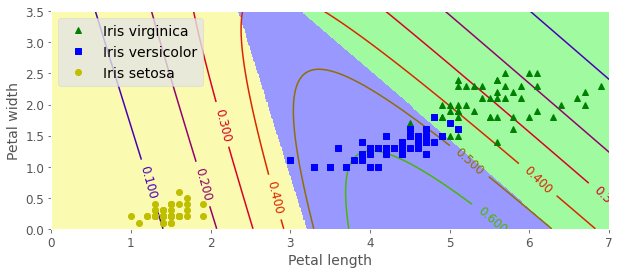

In [85]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

이제 테스트 세트에 대한 모델의 최종 정확도를 측정해 보겠습니다:

In [86]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333

완벽했던 최종 모델의 성능이 조금 떨어졌습니다. 이런 차이는 데이터셋이 작기 때문일 것입니다. 훈련 세트와 검증 세트, 테스트 세트를 어떻게 샘플링했는지에 따라 매우 다른 결과를 얻을 수 있습니다. 몇 번 랜덤 시드를 바꾸고 이 코드를 다시 실행해 보면 결과가 달라지는 것을 확인할 수 있습니다.